<a href="https://colab.research.google.com/github/ArtMla/Confectionery-Data-Visual-Analysis/blob/main/Confectionery_Visual_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install plotly ipywidgets --quiet

#Import Libraries

import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output

#Load Dataset
df = pd.read_excel('/content/Confectionary [4564].xlsx')
df.head()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 24.5 MB/s eta 0:00:00


,Date,Country(UK),Confectionary,Units Sold,Cost(£),Profit(£),Revenue(£)
0,2002-11-11,England,Biscuit,1118.0,2459.6,3130.4,749954.4
1,2002-07-05,England,Biscuit,708.0,1557.6,1982.4,300758.4
2,2001-10-31,England,Biscuit,1269.0,2791.8,3553.2,966216.6
3,2004-09-13,England,Biscuit,1631.0,3588.2,4566.8,1596096.6
4,2004-03-10,England,Biscuit,2240.0,4928.0,6272.0,3010560.0


In [2]:
# Standardise Column names
df.columns = [
    "Date", "Region", "Confectionery", "Units_Sold",
    "Cost_GBP", "Profit_GBP", "Revenue_GBP"
]
df['Confectionery'].unique()

# Fix obvious typos
df['Confectionery'] = df['Confectionery'].replace({
    "Choclate Chunk": "Chocolate Chunk",
    "Caramel nut": "Caramel Nut"
})

#Extract Year and Month from Date
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month

# Add Profit margin column
df['Profit Margin'] = df.apply(lambda r: (r['Profit_GBP'] / r['Revenue_GBP']) if r['Revenue_GBP'] else 0, axis=1)

df_clean = df.dropna(subset=["Units_Sold", "Profit Margin"])

df['Year'].unique()

array([2002, 2001, 2004, 2000, 2005, 2003], dtype=int32)

In [3]:
#Region Summary
region_summary = df.groupby('Region').agg(
    Total_Units_Sold = ('Units_Sold', 'sum'),
    Total_Revenue = ('Revenue_GBP', 'sum'),
    Total_Profit = ('Profit_GBP', 'sum'),
    Avg_Profit_Margin = ('Profit Margin', 'mean')
).reset_index().sort_values('Total_Units_Sold', ascending=False)

print("Region Summary:\n", region_summary)

# Region-wise Sales Doughnut Chart

fig = px.pie(
    region_summary,
    names="Region",
    values="Total_Revenue",     # or "Total_units_sold"
    hole=0.5,                   # This makes it a doughnut
    title="Region-wise Sales (Doughnut Chart)"
)

fig.update_traces(textinfo="percent+label")

fig.show()

Region Summary:
        Region  Total_Units_Sold  Total_Revenue  Total_Profit  \
3    Scotland          379222.0   6.096370e+08      928970.2   
1      Jersey          366566.0   6.360978e+08      913678.7   
2  N. Ireland          307002.0   4.404479e+08      746995.0   
4       Wales          293680.0   3.964996e+08      723059.5   
0     England          280357.0   4.392865e+08      691348.5   

   Avg_Profit_Margin  
3           0.002709  
1           0.003103  
2           0.003774  
4           0.004011  
0           0.003057  


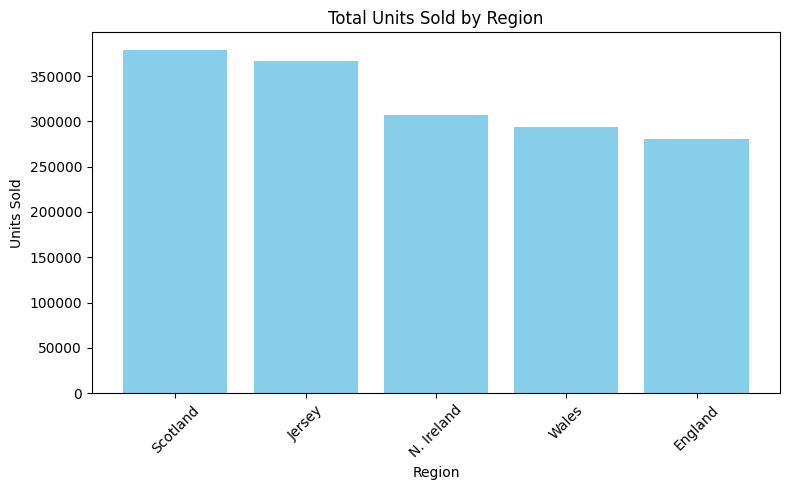

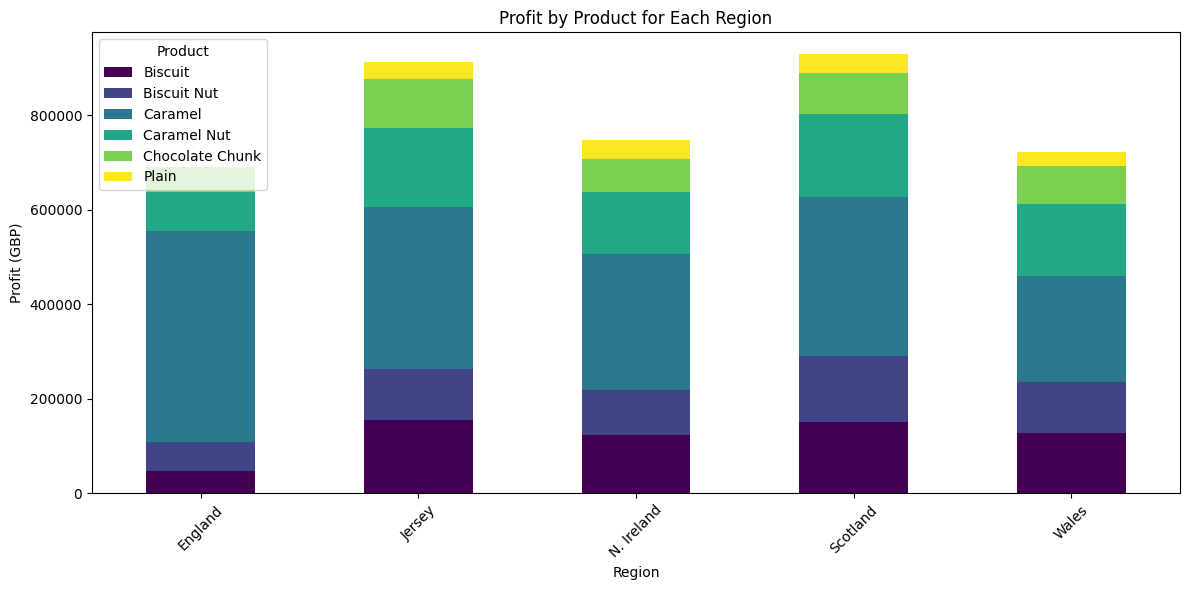

In [4]:
# Bar chart: Total Units Sold
plt.figure(figsize=(8,5))
plt.bar(region_summary['Region'], region_summary['Total_Units_Sold'], color='skyblue')
plt.title('Total Units Sold by Region')
plt.xlabel('Region')
plt.ylabel('Units Sold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Profit by product for each Region

region_profit_summary = df.groupby(['Region', 'Confectionery'])['Profit_GBP'].sum().unstack(fill_value=0)

region_profit_summary.plot(kind='bar', stacked=True, figsize=(12,6), colormap='viridis')
plt.title('Profit by Product for Each Region')
plt.xlabel('Region')
plt.ylabel('Profit (GBP)')
plt.xticks(rotation=45)
plt.legend(title='Product')
plt.tight_layout()
plt.show()

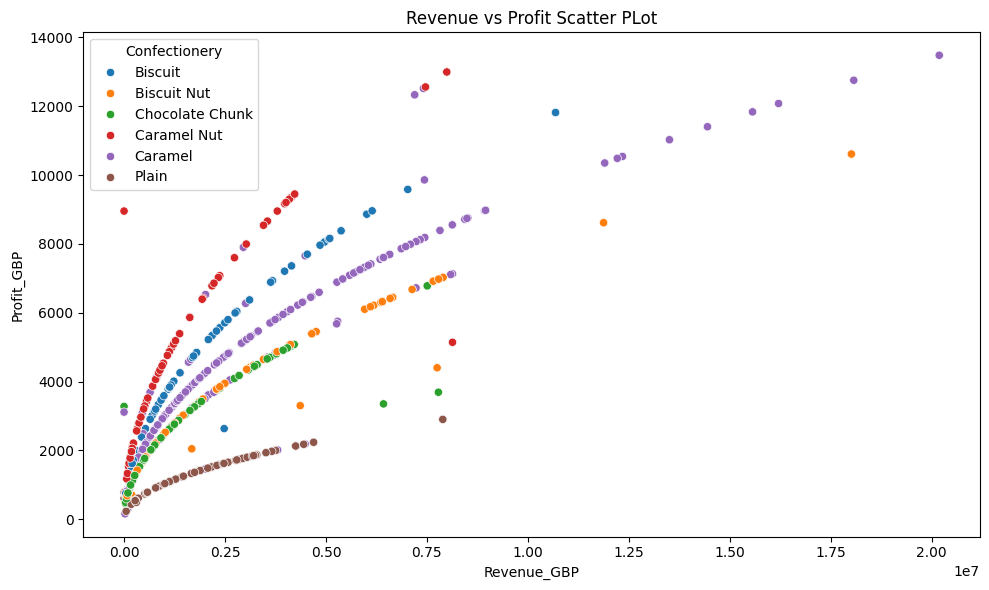

In [5]:
# Revenue vs Profit Scatter Plot

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Revenue_GBP', y='Profit_GBP', hue='Confectionery')
plt.title("Revenue vs Profit Scatter PLot")
plt.xlabel("Revenue_GBP")
plt.ylabel("Profit_GBP")
plt.tight_layout()
plt.show()

## Dashboard

In [6]:
# WIDGETS


metric_dropdown = widgets.Dropdown(
    options=[
        "Revenue Over Time",
        "Profit Over Time",
        "Top Products by Revenue",
        "Top Products by Profit",
        "Sales & Profit by Region",
        "Category-wise Sales Pie Chart",
        "Sales Treemap (Hierarchical)",
        "Profit Margin Over Time",
        "Sales Over Time (By Product)"
    ],
    value="Revenue Over Time",
    description="Metric:"
)

region_dropdown = widgets.Dropdown(
    options=["All"] + sorted(df["Region"].unique()),
    value="All",
    description="Region:"
)

freq_dropdown = widgets.Dropdown(
    options=["Daily", "Monthly", "Yearly"],
    value="Monthly",
    description="Freq:"
)

top_n_slider = widgets.IntSlider(
    value=10,
    min=5,
    max=25,
    step=5,
    description="Top N:"
)

output_area = widgets.Output()



# UPDATE FUNCTION


def update_dashboard(change):
    with output_area:
        clear_output()

        # Filter by region
        if region_dropdown.value != "All":
            data = df[df["Region"] == region_dropdown.value]
        else:
            data = df.copy()

        freq_map = {"Daily": "D", "Monthly": "ME", "Yearly": "YE"}
        metric = metric_dropdown.value


# 1. Revenue Over Time

        if metric == "Revenue Over Time":
            temp = (
                data.set_index("Date")
                .resample(freq_map[freq_dropdown.value])["Revenue_GBP"]
                .sum()
                .reset_index()
            )
            fig = px.line(temp, x="Date", y="Revenue_GBP",
                          title=f"Revenue Over Time [{freq_dropdown.value}]")
            fig.show()


# 2. Profit Over Time

        elif metric == "Profit Over Time":
            temp = (
                data.set_index("Date")
                .resample(freq_map[freq_dropdown.value])["Profit_GBP"]
                .sum()
                .reset_index()
            )
            fig = px.line(temp, x="Date", y="Profit_GBP",
                          title=f"Profit Over Time [{freq_dropdown.value}]")
            fig.show()


# 3. Top Products by Revenue

        elif metric == "Products by Revenue":
            temp = (
                data.groupby("Confectionery")["Revenue_GBP"]
                .sum()
                .nlargest(top_n_slider.value)
                .reset_index()
            )
            fig = px.bar(temp, x="Revenue_GBP", y="Confectionery",
                         title=f"Top {top_n_slider.value} Products by Revenue",
                         orientation="h")
            fig.update_layout(yaxis={"categoryorder": "total ascending"})
            fig.show()


# 4. Top Products by Profit

        elif metric == "Top Products by Profit":
            temp = (
                data.groupby("Confectionery")["Profit_GBP"]
                .sum()
                .nlargest(top_n_slider.value)
                .reset_index()
            )
            fig = px.bar(temp, x="Profit_GBP", y="Confectionery",
                         title=f"Top Products by Profit",
                         orientation="h")
            fig.update_layout(yaxis={"categoryorder": "total ascending"})
            fig.show()


# 5. Sales & Profit by Region

        elif metric == "Sales & Profit by Region":
            temp = data.groupby("Region")[["Units_Sold", "Profit_GBP"]].sum().reset_index()

            fig = px.bar(
                temp,
                x="Region",
                y=["Units_Sold", "Profit_GBP"],
                barmode="group",
                title="Sales & Profit by Region"
            )
            fig.show()


# 6. Category-wise Sales Pie Chart

        elif metric == "Category-wise Sales Pie Chart":
            temp = (
                data.groupby("Confectionery")["Units_Sold"]
                .sum()
                .reset_index()
            )
            fig = px.pie(
                temp,
                names="Confectionery",
                values="Units_Sold",
                title="Category-wise Sales Distribution"
            )
            fig.update_traces(textposition="inside", textinfo="percent+label")
            fig.show()


# 7. Sales vs Profit Scatter Plot

        elif metric == "Sales vs Profit Scatter":
            temp = data[["Units_Sold", "Profit_GBP", "Confectionery"]].dropna()

            fig = px.scatter(
                temp,
                x="Units_Sold",
                y="Profit_GBP",
                color="Confectionery",
                size="Units_Sold",
                hover_name="Confectionery",
                title="Relationship Between Sales (Units Sold) and Profit",
                trendline="ols"
            )
            fig.show()

# 8. Hierarchical Sales Treemap

        elif metric == "Sales Treemap (Hierarchical)":
                # Choose hierarchy available in your data
                # Example: Region → Confectionery → Units_Sold

            temp = data.groupby(["Region", "Confectionery"], as_index=False)["Units_Sold"].sum()

            fig = px.treemap(
                temp,
                path=["Region", "Confectionery"],   # hierarchy levels
                values="Units_Sold",
                color="Units_Sold",
                title="Hierarchical View of Sales (Treemap)",
            )
            fig.show()


# 9. Profit Margin Over Time by Product

        elif metric == "Profit Margin Over Time":

            # Group by product + selected frequency
            temp = (
                data.groupby([
                    pd.Grouper(key="Date", freq=freq_map[freq_dropdown.value]),
                    "Confectionery"
                ])["Profit Margin"]
                .mean()
                .reset_index()
            )

            fig = px.line(
                temp,
                x="Date",
                y="Profit Margin",
                color="Confectionery",
                markers=True,
                title="Profit Margin Over Time by Product"
            )

            fig.update_layout(
                xaxis_title="Date",
                yaxis_title="Profit Margin",
                template="plotly_white"
            )

            fig.show()


# 10:  Sales Over Time (By Product) - Stacked Area Chart

        elif metric == "Sales Over Time (By Product)":
            temp = (
                data.groupby([
                    pd.Grouper(key="Date", freq=freq_map[freq_dropdown.value]),
                    "Confectionery"
                ])["Units_Sold"]
                .sum()
                .reset_index()
            )

            fig = px.area(
                temp,
                x="Date",
                y="Units_Sold",
                color="Confectionery",
                title="Sales Over Time by Product (Stacked Area Chart)"
            )

            fig.update_layout(
                xaxis_title="Date",
                yaxis_title="Units Sold",
                legend_title="Product",
                template="plotly_white"
            )

            fig.show()

# LINK WIDGETS TO FUNCTION


metric_dropdown.observe(update_dashboard, names="value")
region_dropdown.observe(update_dashboard, names="value")
freq_dropdown.observe(update_dashboard, names="value")
top_n_slider.observe(update_dashboard, names="value")


# DISPLAY DASHBOARD


display(metric_dropdown, region_dropdown, freq_dropdown, top_n_slider, output_area)

update_dashboard(None)


Dropdown(description='Metric:', options=('Revenue Over Time', 'Profit Over Time', 'Top Products by Revenue', '…

Dropdown(description='Region:', options=('All', 'England', 'Jersey', 'N. Ireland', 'Scotland', 'Wales'), value…

Dropdown(description='Freq:', index=1, options=('Daily', 'Monthly', 'Yearly'), value='Monthly')

IntSlider(value=10, description='Top N:', max=25, min=5, step=5)

Output()